# Настройка параметров кластеризации DBSCAN по значениям метрики силуэта

При настройке параметров модели важным является вопрос, какие значения параметров считать оптимальными. Это связано с тем, что наилучшие значения метрики модели не всегда говорят о том, что модель действительно лучшая. Часто график метрики дает возрастающую кривую, и, казалось бы, чем выше, тем лучше, но кривая содержит так называемую локтевую точку: левее нее рост идет быстро (и есть смысл наращивать метрику), а правее нее рост, хотя формально и  продолжается, но настолько не выражен, что смысла усиливать метрику никакого нет.

Как правило, параметры модели подбирабтся именно по локтевой точке. Но проблема в том, что выразить ее аналитически через наблюдаемые значения метрики нельзя. В [одной из предыдущих работ](https://github.com/vladimir-mosin/fold-point) мы предложили алгоритмический метод поиска локтевой точки, который, как нам кажестя, дает вполне приемлемые результаты. В этом исследовании мы используем предложенный нами алгоритм к ситуации, когда анализируется модель кластеризации DBSCAN: нас интересует, 

1. сможем ли мы подобрать гиперпараметры модели автоматически
2. условия, при которых такой автоматический подбор будет работать хорошо (и наоборот: при каких условиях он будет работать плохо).

[Полный текст этого исследования](paper.pdf) доступен в формате pdf.

In [4]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import sklearn.linear_model as skl
import matplotlib.pyplot as plt

from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score
from sklearn.datasets import make_blobs


# Это та самая функция поиска локтевой точки
def fold_point(A, B):

    S_line = ((B - B.mean())**2).sum()

    R2_list = []

    shift = 3

    for i in np.arange(shift, len(A) - shift):

        X_left = A[:i].reshape(-1, 1)
        y_left = B[:i]

        model_left = skl.LinearRegression()
        model_left.fit(X_left, y_left)

        y_pred_left = model_left.predict(X_left)

        S_star_left = ((y_pred_left - y_left)**2).sum()

        X_right = A[i:].reshape(-1, 1)
        y_right = B[i:]

        model_right = skl.LinearRegression()
        model_right.fit(X_right, y_right)

        y_pred_right = model_right.predict(X_right)

        S_star_right = ((y_pred_right - y_right)**2).sum()

        S_star = S_star_left + S_star_right

        R2 = 1 - S_star/S_line

        R2_list.append(R2)
    
    fold_inedex_draft = np.array(R2_list).argmax() + shift
    
    if B[fold_inedex_draft] >= B[fold_inedex_draft - 1]:
    
        fold_index = fold_inedex_draft
        
    else:
        
        fold_index = fold_inedex_draft - 1
    
    return fold_index

## Алгоритм настройки параметров кластеризации DBSCAN по локтевой точке метрики силуэта

### Генерация данных

In [21]:
X, _ = make_blobs(n_samples=500, centers=3, cluster_std=0.5)

### Кртинка с исходными данными

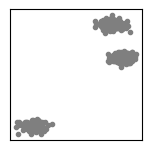

In [22]:
fig_size = (1.7, 1.7)

plt.figure(figsize = fig_size)
plt.xticks([])
plt.yticks([])
plt.scatter(X[:, 0], X[:, 1], marker='.', color ='tab:grey')

plt.show()

### Сетка для гиперпараметров `eps` и `min_samples`

In [23]:
eps_grid = np.arange(0.1, 2, 0.1)
min_samples_grid = np.arange(1, 15, 1)

### Таблицы для результатов

In [24]:
# Сюда будем записывать метрики
result = pd.DataFrame(columns = eps_grid, index = min_samples_grid)

# Сюда будем записывать, на сколько кластеров произойдет разбиение
result_n_clust = pd.DataFrame(columns = eps_grid, index = min_samples_grid)

# Сюда будем записывать, сколько объектов уйдет в выбросы
result_n_out = pd.DataFrame(columns = eps_grid, index = min_samples_grid)

### Цикл по заполнению таблиц

In [25]:
cols = result.columns
ind = result.index

for i in range(len(cols)):

    for j in range(len(ind)):

        # Заводим модель и фитим ее на X
        clust = DBSCAN(eps=cols[i], min_samples=ind[j])
        clust.fit(X)
        labels = clust.labels_
        
        # Исключаем ситуации, когда все объекты отнесены к одному кластеру, 
        # или, наоборот, каждый объект образует собственный кластер
        # Тогда не получится посчитать метрику силуэта
        if (len(set(labels)) > 1) and (len(set(labels)) < len(X)):
            result[cols[i]][ind[j]] = silhouette_score(X, labels)
        
        # Считаем, сколько всего различных меток использовалось в списке меток
        result_n_clust[cols[i]][ind[j]] = len(set(labels))
        
        # Считаем, сколько раз в сипок меток вошла -1 (это и есть число выбросов)
        result_n_out[cols[i]][ind[j]] = list(labels).count(-1)

# Так как возможны ситуации, что в силу условия в цикле не все ячейки заполнены, 
# удаляем из датафрейма соответствующие позиции
# Если все заполнено, то ничего не удаляется
result = result.T.dropna().T

In [26]:
result

,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0,1.1,1.2,1.3,1.4,1.5,1.6,1.7,1.8,1.9
1,-0.12332,-0.019352,0.284132,0.367791,0.606223,0.606223,0.751133,0.873123,0.873123,0.873123,0.873123,0.873123,0.873123,0.873123,0.873123,0.873123,0.873123,0.873123
2,-0.062583,0.626314,0.537501,0.684601,0.858909,0.858909,0.751133,0.873123,0.873123,0.873123,0.873123,0.873123,0.873123,0.873123,0.873123,0.873123,0.873123,0.873123
3,0.019415,0.626314,0.700287,0.843131,0.858909,0.858909,0.751133,0.873123,0.873123,0.873123,0.873123,0.873123,0.873123,0.873123,0.873123,0.873123,0.873123,0.873123
4,0.085233,0.623351,0.832742,0.843131,0.858909,0.858909,0.751133,0.873123,0.873123,0.873123,0.873123,0.873123,0.873123,0.873123,0.873123,0.873123,0.873123,0.873123
5,0.15895,0.757529,0.832742,0.844646,0.858909,0.858909,0.751133,0.873123,0.873123,0.873123,0.873123,0.873123,0.873123,0.873123,0.873123,0.873123,0.873123,0.873123
6,-0.014749,0.727199,0.832742,0.844295,0.844867,0.858909,0.751133,0.873123,0.873123,0.873123,0.873123,0.873123,0.873123,0.873123,0.873123,0.873123,0.873123,0.873123
7,0.207224,0.695694,0.8134,0.844295,0.844867,0.858909,0.751133,0.873123,0.873123,0.873123,0.873123,0.873123,0.873123,0.873123,0.873123,0.873123,0.873123,0.873123
8,0.286309,0.664705,0.811263,0.844295,0.852598,0.858909,0.751133,0.873123,0.873123,0.873123,0.873123,0.873123,0.873123,0.873123,0.873123,0.873123,0.873123,0.873123
9,0.189175,0.641932,0.808457,0.832232,0.852598,0.858909,0.751133,0.873123,0.873123,0.873123,0.873123,0.873123,0.873123,0.873123,0.873123,0.873123,0.873123,0.873123
10,-0.010144,0.628926,0.794056,0.832232,0.852598,0.858909,0.751133,0.873123,0.873123,0.873123,0.873123,0.873123,0.873123,0.873123,0.873123,0.873123,0.873123,0.873123


In [27]:
result_n_clust

,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0,1.1,1.2,1.3,1.4,1.5,1.6,1.7,1.8,1.9
1,235,61,27,13,8,5,5,4,3,3,3,3,3,3,3,3,3,3,3
2,83,21,5,6,5,4,4,4,3,3,3,3,3,3,3,3,3,3,3
3,46,12,5,5,4,4,4,4,3,3,3,3,3,3,3,3,3,3,3
4,28,8,5,4,4,4,4,4,3,3,3,3,3,3,3,3,3,3,3
5,20,8,4,4,4,4,4,4,3,3,3,3,3,3,3,3,3,3,3
6,11,8,4,4,4,4,4,4,3,3,3,3,3,3,3,3,3,3,3
7,5,5,4,4,4,4,4,4,3,3,3,3,3,3,3,3,3,3,3
8,3,4,4,4,4,4,4,4,3,3,3,3,3,3,3,3,3,3,3
9,3,4,4,4,4,4,4,4,3,3,3,3,3,3,3,3,3,3,3
10,2,5,4,4,4,4,4,4,3,3,3,3,3,3,3,3,3,3,3


In [28]:
result_n_out

,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0,1.1,1.2,1.3,1.4,1.5,1.6,1.7,1.8,1.9
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,153,41,23,8,4,2,2,1,0,0,0,0,0,0,0,0,0,0,0
3,227,59,23,10,6,2,2,1,0,0,0,0,0,0,0,0,0,0,0
4,300,80,24,13,6,2,2,1,0,0,0,0,0,0,0,0,0,0,0
5,352,101,36,13,7,2,2,1,0,0,0,0,0,0,0,0,0,0,0
6,411,117,44,13,8,3,2,1,0,0,0,0,0,0,0,0,0,0,0
7,453,152,54,18,8,3,2,1,0,0,0,0,0,0,0,0,0,0,0
8,469,176,63,19,8,4,2,1,0,0,0,0,0,0,0,0,0,0,0
9,479,204,70,20,11,4,2,1,0,0,0,0,0,0,0,0,0,0,0
10,490,229,74,25,11,4,2,1,0,0,0,0,0,0,0,0,0,0,0


### Наилучшее значение гиперпараметра `min_samples`

In [32]:
# Считаем среднеие значения из таблицы метрик по строкам
min_samples_means_list = list(result.T.mean())
# Наилучшим считаем то значение параметра min_samples, которое соответствует номеру с наибольшим значением метрики
min_samples_best = min_samples_means_list.index(max(min_samples_means_list))

In [33]:
min_samples_means_list

[0.670954488798016,
 0.769951965928212,
 0.7923583849362713,
 0.8032089320207535,
 0.8148427984842063,
 0.8027082258715444,
 0.8122152287535219,
 0.8151980464137684,
 0.807710510877534,
 0.7951145929727947,
 0.7810210270923361,
 0.7736205599746261,
 0.7669697992647169,
 0.7575953482277049]

In [34]:
min_samples_best

7

Тем самым, мы выделили наилучшее значение параметра `min_samples`. Дальше мы его фиксируем. А что касается значения параметра `epd`, то его мы будем подбирать по локтевой точке.

### Поиск локтевой точки метрики силуета в зависимости от радиуса кластеризации `eps`

In [ ]:
# Заводим входные массивы
A = np.array(result.columns)
B = result.iloc[min_samples_best].to_numpy()

# Применяем функцию
fold_ind = fold_point(A, B)

# Присваиваем найденное значение как наилучшее для eps
eps_best = result.columns[fold_ind]

### Картинки

#### Пучок кривых

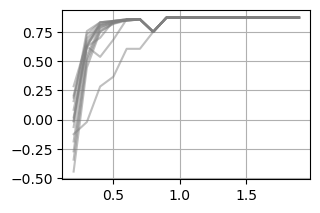

In [37]:
# Это визуализация строк таблицы result
plt.figure(figsize = (3.2, 2.2))
plt.grid()
for i in range(len(result)):
    plt.plot(np.array(result.columns), result.iloc[i].to_numpy(), '-', color = 'grey', alpha = 0.5)
x_l = plt.xlim()
y_l = plt.ylim()
plt.show()

#### Лучшая кривая

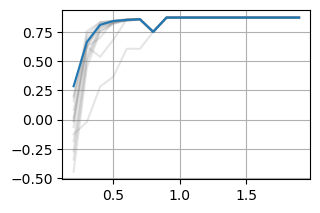

In [38]:
# Это та кривая, которая лежит выше всех в пучке по совокупности значений (у нее среднее самое большое)
plt.figure(figsize = (3.2, 2.2))
plt.grid()
plt.xlim(x_l)
plt.ylim(y_l)

for i in range(len(result)):
    plt.plot(np.array(result.columns), result.iloc[i].to_numpy(), '-', color = 'grey', alpha = 0.2)
plt.plot(np.array(result.columns), result.iloc[min_samples_best].to_numpy(), '-', color = 'tab:blue', 
         label = 'min_samples_best = ' + str(min_samples_best))
plt.show()

#### Локтевая точка на лучшей кривой

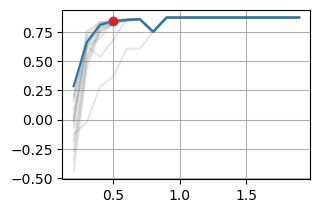

In [41]:
plt.figure(figsize = (3.2, 2.2))
plt.grid()
plt.xlim(x_l)
plt.ylim(y_l)

for i in range(len(result)):
    plt.plot(np.array(result.columns), result.iloc[i].to_numpy(), '-', color = 'grey', alpha = 0.2)
plt.plot(np.array(result.columns), result.iloc[min_samples_best].to_numpy(), '-', color = 'tab:blue', 
         label = 'min_samples_best = ' + str(min_samples_best))
plt.plot(eps_best, result.iloc[min_samples_best][eps_best], 'o', color = 'tab:red', 
         label = 'eps_best = ' + str(round(eps_best, 4)))
plt.show()

### Кластеризация с оптимальными параметрами

In [42]:
# Присваиваем параметрам найденные значения
# Фитим модель 
clust = DBSCAN(eps=eps_best, min_samples=min_samples_best)
clust.fit(X)
labels = clust.labels_

### Итоговая картинка

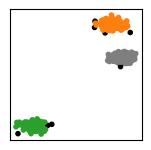

Кластеров 3
Выбросов 1.6%


In [43]:
# Это просто прикольная цветовая палитра. Можно без нее
color_map = plt.cm.colors.ListedColormap(['black', 
                                          'tab:cyan', 
                                          'tab:olive', 
                                          'tab:grey', 
                                          'tab:pink', 
                                          'tab:brown', 
                                          'tab:purple', 
                                          'tab:green', 
                                          'tab:red',
                                          'tab:blue',
                                          'tab:orange'
                                         ])
plt.figure(figsize = fig_size)
plt.xticks([])
plt.yticks([])
plt.scatter(X[:, 0], X[:, 1], marker='.', c=labels, cmap=color_map)
# plt.savefig('Кластеры.png', dpi = 300, bbox_inches = 'tight', pad_inches = 0.02)
plt.show()

print('Кластеров ' + str(len(set(labels))-1))
print('Выбросов ' + str(round(100*(list(labels).count(-1)/len(X)), 2)) + '%')

## Эксперименты

Здесь мы пробуем различные типы данных: 
    
1. с четким разделением на кластеры
2. с размазаным, невыраженым разделением

### Данные с четким разделением на кластеры

При формировании данных указываем маленькое значение `cluster_std`, тогда разбиение на кластеры получается четким. 

Потом можно много раз запускать ячейку и любоваться результатом.

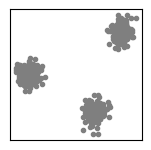

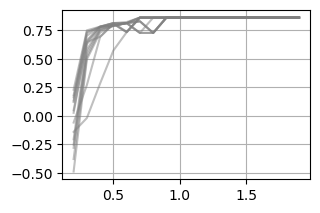

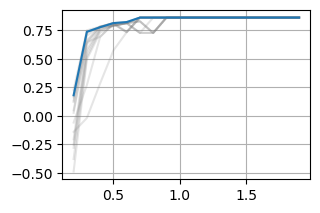

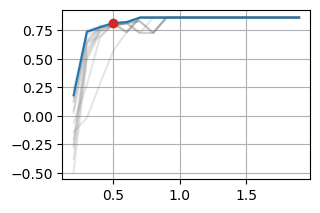

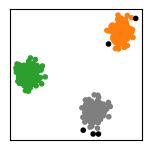

Кластеров 3
Выбросов 1.0%


In [44]:
X, _ = make_blobs(n_samples=500, centers=3, cluster_std=0.5)


fig_size = (1.7, 1.7)

plt.figure(figsize = fig_size)
plt.xticks([])
plt.yticks([])
plt.scatter(X[:, 0], X[:, 1], marker='.', color ='tab:grey')

plt.show()

eps_grid = np.arange(0.1, 2, 0.1)
min_samples_grid = np.arange(1, 15, 1)

result = pd.DataFrame(columns = eps_grid, index = min_samples_grid)
result_n_clust = pd.DataFrame(columns = eps_grid, index = min_samples_grid)
result_n_out = pd.DataFrame(columns = eps_grid, index = min_samples_grid)

cols = result.columns
ind = result.index

for i in range(len(cols)):

    for j in range(len(ind)):

        clust = DBSCAN(eps=cols[i], min_samples=ind[j])
        clust.fit(X)
        labels = clust.labels_
        if (len(set(labels)) > 1) and (len(set(labels)) < len(X)):
            result[cols[i]][ind[j]] = silhouette_score(X, labels)
        result_n_clust[cols[i]][ind[j]] = len(set(labels))
        result_n_out[cols[i]][ind[j]] = list(labels).count(-1)
    
result = result.T.dropna().T

min_samples_means_list = list(result.T.mean())

min_samples_best = min_samples_means_list.index(max(min_samples_means_list))

A = np.array(result.columns)

B = result.iloc[min_samples_best].to_numpy()

fold_ind = fold_point(A, B)

eps_best = result.columns[fold_ind]

eps_max = result.columns[-1]

plt.figure(figsize = (3.2, 2.2))
plt.grid()
for i in range(len(result)):
    plt.plot(np.array(result.columns), result.iloc[i].to_numpy(), '-', color = 'grey', alpha = 0.5)
x_l = plt.xlim()
y_l = plt.ylim()
plt.show()

plt.figure(figsize = (3.2, 2.2))
plt.grid()
plt.xlim(x_l)
plt.ylim(y_l)

for i in range(len(result)):
    plt.plot(np.array(result.columns), result.iloc[i].to_numpy(), '-', color = 'grey', alpha = 0.2)
plt.plot(np.array(result.columns), result.iloc[min_samples_best].to_numpy(), '-', color = 'tab:blue', 
         label = 'min_samples_best = ' + str(min_samples_best))
plt.show()

plt.figure(figsize = (3.2, 2.2))
plt.grid()
plt.xlim(x_l)
plt.ylim(y_l)

for i in range(len(result)):
    plt.plot(np.array(result.columns), result.iloc[i].to_numpy(), '-', color = 'grey', alpha = 0.2)
plt.plot(np.array(result.columns), result.iloc[min_samples_best].to_numpy(), '-', color = 'tab:blue', 
         label = 'min_samples_best = ' + str(min_samples_best))
plt.plot(eps_best, result.iloc[min_samples_best][eps_best], 'o', color = 'tab:red', 
         label = 'eps_best = ' + str(round(eps_best, 4)))
plt.show()


clust = DBSCAN(eps=eps_best, min_samples=min_samples_best)
clust.fit(X)
labels = clust.labels_

color_map = plt.cm.colors.ListedColormap(['black', 
                                          'tab:cyan', 
                                          'tab:olive', 
                                          'tab:grey', 
                                          'tab:pink', 
                                          'tab:brown', 
                                          'tab:purple', 
                                          'tab:green', 
                                          'tab:red',
                                          'tab:blue',
                                          'tab:orange'
                                         ])
plt.figure(figsize = fig_size)
plt.xticks([])
plt.yticks([])
plt.scatter(X[:, 0], X[:, 1], marker='.', c=labels, cmap=color_map)
plt.show()

print('Кластеров ' + str(len(set(labels))-1))
print('Выбросов ' + str(round(100*(list(labels).count(-1)/len(X)), 2)) + '%')

Локтевая точка метрики силуэта выражена ярко. И когда мы указываем параметры кластеризации, соответствующие локтевой точке, все получается очень хорошо: 

1. разбиение соответствует тому, что мы сгенерировали в синтетике, 
2. выбросов мало.

### Данные с нечетким разделением на кластеры

Здесь, наоборт: указываем высокое значение `cluster_std`. Кластеры получаются размазанными. И тоже смотрим, как работает алгоритм.

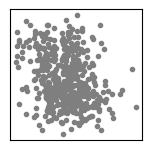

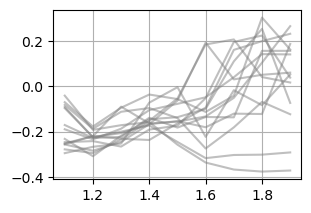

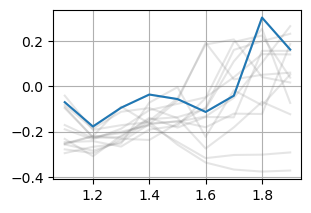

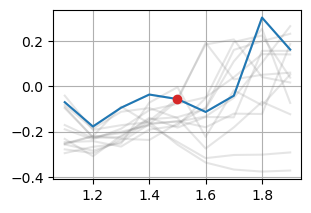

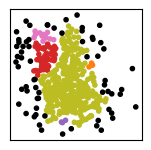

Кластеров 5
Выбросов 13.2%


In [45]:
X, _ = make_blobs(n_samples=500, centers=3, cluster_std=5)


fig_size = (1.7, 1.7)

plt.figure(figsize = fig_size)
plt.xticks([])
plt.yticks([])
plt.scatter(X[:, 0], X[:, 1], marker='.', color ='tab:grey')

plt.show()

eps_grid = np.arange(0.1, 2, 0.1)
min_samples_grid = np.arange(1, 15, 1)

result = pd.DataFrame(columns = eps_grid, index = min_samples_grid)
result_n_clust = pd.DataFrame(columns = eps_grid, index = min_samples_grid)
result_n_out = pd.DataFrame(columns = eps_grid, index = min_samples_grid)

cols = result.columns
ind = result.index

for i in range(len(cols)):

    for j in range(len(ind)):

        clust = DBSCAN(eps=cols[i], min_samples=ind[j])
        clust.fit(X)
        labels = clust.labels_
        if (len(set(labels)) > 1) and (len(set(labels)) < len(X)):
            result[cols[i]][ind[j]] = silhouette_score(X, labels)
        result_n_clust[cols[i]][ind[j]] = len(set(labels))
        result_n_out[cols[i]][ind[j]] = list(labels).count(-1)
    
result = result.T.dropna().T

min_samples_means_list = list(result.T.mean())

min_samples_best = min_samples_means_list.index(max(min_samples_means_list))

A = np.array(result.columns)

B = result.iloc[min_samples_best].to_numpy()

fold_ind = fold_point(A, B)

eps_best = result.columns[fold_ind]

eps_max = result.columns[-1]

plt.figure(figsize = (3.2, 2.2))
plt.grid()
for i in range(len(result)):
    plt.plot(np.array(result.columns), result.iloc[i].to_numpy(), '-', color = 'grey', alpha = 0.5)
x_l = plt.xlim()
y_l = plt.ylim()
plt.show()

plt.figure(figsize = (3.2, 2.2))
plt.grid()
plt.xlim(x_l)
plt.ylim(y_l)

for i in range(len(result)):
    plt.plot(np.array(result.columns), result.iloc[i].to_numpy(), '-', color = 'grey', alpha = 0.2)
plt.plot(np.array(result.columns), result.iloc[min_samples_best].to_numpy(), '-', color = 'tab:blue', 
         label = 'min_samples_best = ' + str(min_samples_best))
plt.show()

plt.figure(figsize = (3.2, 2.2))
plt.grid()
plt.xlim(x_l)
plt.ylim(y_l)

for i in range(len(result)):
    plt.plot(np.array(result.columns), result.iloc[i].to_numpy(), '-', color = 'grey', alpha = 0.2)
plt.plot(np.array(result.columns), result.iloc[min_samples_best].to_numpy(), '-', color = 'tab:blue', 
         label = 'min_samples_best = ' + str(min_samples_best))
plt.plot(eps_best, result.iloc[min_samples_best][eps_best], 'o', color = 'tab:red', 
         label = 'eps_best = ' + str(round(eps_best, 4)))
plt.show()

clust = DBSCAN(eps=eps_best, min_samples=min_samples_best)
clust.fit(X)
labels = clust.labels_

color_map = plt.cm.colors.ListedColormap(['black', 
                                          'tab:cyan', 
                                          'tab:olive', 
                                          'tab:grey', 
                                          'tab:pink', 
                                          'tab:brown', 
                                          'tab:purple', 
                                          'tab:green', 
                                          'tab:red',
                                          'tab:blue',
                                          'tab:orange'
                                         ])
plt.figure(figsize = fig_size)
plt.xticks([])
plt.yticks([])
plt.scatter(X[:, 0], X[:, 1], marker='.', c=labels, cmap=color_map)
plt.show()

print('Кластеров ' + str(len(set(labels))-1))
print('Выбросов ' + str(round(100*(list(labels).count(-1)/len(X)), 2)) + '%')

Видим, что локтевой точки и близко нет. И если мы пытаемся присвоить кластеризаторы гиперпараметры, соответствующие все-таки найденной локтевой точке (а наш алгоритм ее поиска учтроен так, что она все равно будет надена, неважно, хорошая она или плохая), получается все очень плохо:
1. число кластеров не соответствует тому, что мы указывали на этапе генрации,
2. выборосов очень много.